<a href="https://colab.research.google.com/github/RoodionMarkelov/graphs/blob/master/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импорт пакетов

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
from plotly.offline import iplot
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from google.colab import files
import torch.optim as optim
import io
from datetime import datetime

device = "cuda"

In [ ]:
torch.cuda.is_available()

True

Пункт 1

Загрузка Датасета

In [ ]:
data_to_load = files.upload()
print(data_to_load)

Saving dataset.csv to dataset.csv
{'dataset.csv': b'2008-01-10,-20,765,\xd0\x92 2\xd0\xbc/\xd1\x81,-22,765,\xd0\x92 2\xd0\xbc/\xd1\x81\n2008-01-11,-20,764,\xd0\xa8,-24,764,\xd0\xa8\n2008-01-12,-20,762,\xd0\x97 2\xd0\xbc/\xd1\x81,-20,761,\xd0\x97 2\xd0\xbc/\xd1\x81\n2008-01-13,-9,756,\xd0\xae\xd0\x97 3\xd0\xbc/\xd1\x81,-7,754,\xd0\xae\xd0\x97 3\xd0\xbc/\xd1\x81\n2008-01-14,-6,751,\xd0\xae\xd0\x97 2\xd0\xbc/\xd1\x81,-4,752,\xd0\xae\xd0\x97 2\xd0\xbc/\xd1\x81\n2008-01-15,-1,753,\xd0\x97 1\xd0\xbc/\xd1\x81,-2,754,\xd0\x97 1\xd0\xbc/\xd1\x81\n2008-01-16,-1,759,\xd0\xa8,-2,762,\xd0\xa8\n2008-01-17,-4,765,\xd0\xae 3\xd0\xbc/\xd1\x81,-4,765,\xd0\xae 3\xd0\xbc/\xd1\x81\n2008-01-18,-8,765,\xd0\xae 1\xd0\xbc/\xd1\x81,-10,765,\xd0\xae 1\xd0\xbc/\xd1\x81\n2008-01-19,-9,765,\xd0\xa8,-12,765,\xd0\xa8\n2008-01-20,-9,762,\xd0\xae 3\xd0\xbc/\xd1\x81,-14,762,\xd0\xae 3\xd0\xbc/\xd1\x81\n2008-01-21,-15,759,\xd0\x92 2\xd0\xbc/\xd1\x81,-17,759,\xd0\x92 2\xd0\xbc/\xd1\x81\n2008-01-22,-13,753,\xd0\x92 4\xd0\x

In [ ]:
import io
dframe = pd.read_csv(io.BytesIO(data_to_load['dataset.csv']), names=[
            "Date",
            "Temperature",
            "Presure_morning",
            "Wind_morning",
            "Temp_evening",
            "Presure_evening",
            "Wind_evening",
        ])
df = dframe.iloc[:, :2]

df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
if not df.index.is_monotonic_increasing:
    df = df.sort_index()
df = df.dropna() if not ((df.isnull().sum()).eq(0).all()) else df
print(df)

            Temperature
Date                   
2008-01-10        -20.0
2008-01-11        -20.0
2008-01-12        -20.0
2008-01-13         -9.0
2008-01-14         -6.0
...                 ...
2023-11-01         12.0
2023-11-02         13.0
2023-11-03          6.0
2023-11-04          5.0
2023-11-05          6.0

[5697 rows x 1 columns]


In [ ]:
def plot_dataset(df:pd.DataFrame , title:str)->None:
    '''
    Функция рисует график по данным из датасета.
    Args:
      df: pd.DataFrame;
      title: str;

    Return:
      None
    '''
    data = []

    value = go.Scatter(
        x=df.index,
        y=df.Temperature,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Дата", ticklen=5, zeroline=False),
        yaxis=dict(title="Температура", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)

plot_dataset(df,"Изменение температуры")

In [ ]:
def generate_time_lags(df: pd.DataFrame, n_lags: int) -> pd.DataFrame:
    '''
    Функция генерирует лаги на основе прошлых значений.
    Args:
      df: pd.DataFrame;
      n_lags: int;

    Return:
      DataFrame
    '''
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["Temperature"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

input_dim = 100

df_timelags = generate_time_lags(df, input_dim)
print(df_timelags)

            Temperature  lag1  lag2  lag3  lag4  lag5  lag6  lag7  lag8  lag9  \
Date                                                                            
2008-04-19         12.0  12.0  11.0   8.0   8.0   9.0  20.0  21.0  22.0  21.0   
2008-04-20         15.0  12.0  12.0  11.0   8.0   8.0   9.0  20.0  21.0  22.0   
2008-04-21         19.0  15.0  12.0  12.0  11.0   8.0   8.0   9.0  20.0  21.0   
2008-04-22         18.0  19.0  15.0  12.0  12.0  11.0   8.0   8.0   9.0  20.0   
2008-04-23          9.0  18.0  19.0  15.0  12.0  12.0  11.0   8.0   8.0   9.0   
...                 ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2023-11-01         12.0  11.0   2.0   6.0   2.0  -1.0   1.0  -1.0  11.0   5.0   
2023-11-02         13.0  12.0  11.0   2.0   6.0   2.0  -1.0   1.0  -1.0  11.0   
2023-11-03          6.0  13.0  12.0  11.0   2.0   6.0   2.0  -1.0   1.0  -1.0   
2023-11-04          5.0   6.0  13.0  12.0  11.0   2.0   6.0   2.0  -1.0   1.0   
2023-11-05          6.0   5.

<ipython-input-9-de2676ee7292>:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Пункт 2.

In [ ]:
def feature_label_split(df: pd.DataFrame, target_col: str):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_val_test_split(df, target_col):
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.1, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, test_size=0.1, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_timelags, 'Temperature')

In [ ]:
X, y = feature_label_split(df, 'Temperature')
print(X)
print(y)
print(X_train)
print(X_val)
print(X_test)

Пункт 3

In [ ]:
def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

In [ ]:
scaler = get_scaler('minmax')
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)
y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

In [ ]:
print(X_train)
print(X_train_arr)

            lag1  lag2  lag3  lag4  lag5  lag6  lag7  lag8  lag9  lag10  ...  \
Date                                                                     ...   
2008-04-19  12.0  11.0   8.0   8.0   9.0  20.0  21.0  22.0  21.0   20.0  ...   
2008-04-20  12.0  12.0  11.0   8.0   8.0   9.0  20.0  21.0  22.0   21.0  ...   
2008-04-21  15.0  12.0  12.0  11.0   8.0   8.0   9.0  20.0  21.0   22.0  ...   
2008-04-22  19.0  15.0  12.0  12.0  11.0   8.0   8.0   9.0  20.0   21.0  ...   
2008-04-23  18.0  19.0  15.0  12.0  12.0  11.0   8.0   8.0   9.0   20.0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...    ...  ...   
2018-03-17  -2.0  -5.0  -7.0  -8.0  -7.0  -9.0  -4.0  -4.0  -8.0   -8.0  ...   
2018-03-18  -6.0  -2.0  -5.0  -7.0  -8.0  -7.0  -9.0  -4.0  -4.0   -8.0  ...   
2018-03-19  -8.0  -6.0  -2.0  -5.0  -7.0  -8.0  -7.0  -9.0  -4.0   -4.0  ...   
2018-03-20 -10.0  -8.0  -6.0  -2.0  -5.0  -7.0  -8.0  -7.0  -9.0   -4.0  ...   
2018-03-21  -1.0 -10.0  -8.0  -6.0  -2.0

Пункт 4

In [ ]:
batch_size = 96
learning_rate = 0.001

In [ ]:
train_features = torch.Tensor(X_train_arr).to("cuda:0")
train_targets = torch.Tensor(y_train_arr).to("cuda:0")
val_features = torch.Tensor(X_val_arr).to("cuda:0")
val_targets = torch.Tensor(y_val_arr).to("cuda:0")
test_features = torch.Tensor(X_test_arr).to("cuda:0")
test_targets = torch.Tensor(y_test_arr).to("cuda:0")

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

Пункт 5 - 8

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, layer_dim: int, output_dim: int, dropout_prob: float) -> None:
        """The __init__ method that initiates an RNN instance.

        Args:
            input_dim (int): The number of nodes in the input layer(входной слой)
            hidden_dim (int): The number of nodes in each layer(скрытый слой)
            layer_dim (int): The number of layers in the network(кол-во слоев нейронки)
            output_dim (int): The number of nodes in the output layer(выходной слой)
            dropout_prob (float): The probability of nodes being dropped out(вер-ть исключить эл-т)

        """
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(
            0), self.hidden_dim).requires_grad_().to("cuda:0")

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [ ]:
class Optimization:
    """Optimization is a helper class that allows training, validation, prediction.

    Optimization is a helper class that takes model, loss function, optimizer function
    learning scheduler (optional), early stopping (optional) as inputs. In return, it
    provides a framework to train and validate the models, and to predict future values
    based on the models.

    Attributes:
        model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
        loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
        optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        train_losses (list[float]): The loss values from the training
        val_losses (list[float]): The loss values from the validation
        last_epoch (int): The number of epochs that the models is trained
    """
    def __init__(self, model, loss_fn, optimizer):
        """
        Args:
            model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
            loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
            optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        """
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []

    def train_step(self, x, y):
        """The method train_step completes one step of training.

        Given the features (x) and the target values (y) tensors, the method completes
        one step of the training. First, it activates the train mode to enable back prop.
        After generating predicted values (yhat) by doing forward propagation, it calculates
        the losses by using the loss function. Then, it computes the gradients by doing
        back propagation and updates the weights by calling step() function.

        Args:
            x (torch.Tensor): Tensor for features to train one step
            y (torch.Tensor): Tensor for target values to calculate losses

        """
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size, n_epochs=50, n_features=1):
        """The method train performs the model training

        The method takes DataLoaders for training and validation datasets, batch size for
        mini-batch training, number of epochs to train, and number of features as inputs.
        Then, it carries out the training by iteratively calling the method train_step for
        n_epochs times. If early stopping is enabled, then it  checks the stopping condition
        to decide whether the training needs to halt before n_epochs steps. Finally, it saves
        the model in a designated file path.

        Args:
            train_loader (torch.utils.data.DataLoader): DataLoader that stores training data
            val_loader (torch.utils.data.DataLoader): DataLoader that stores validation data
            batch_size (int): Batch size for mini-batch training
            n_epochs (int): Number of epochs, i.e., train steps, to train
            n_features (int): Number of feature columns

        """
        model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        """The method evaluate performs the model evaluation

        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future.

        Args:
            test_loader (torch.utils.data.DataLoader): DataLoader that stores test data
            batch_size (int): Batch size for mini-batch training
            n_features (int): Number of feature columns

        Returns:
            list[float]: The values predicted by the model
            list[float]: The actual values in the test set.

        """
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to('cpu').detach().numpy())
                values.append(y_test.to('cpu').detach().numpy())

        return predictions, values

    def plot_losses(self):
        """The method plots the calculated loss values for training and validation
        """
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

[1/20] Training loss: 0.0508	 Validation loss: 0.0081
[2/20] Training loss: 0.0111	 Validation loss: 0.0058
[3/20] Training loss: 0.0094	 Validation loss: 0.0062
[4/20] Training loss: 0.0088	 Validation loss: 0.0049
[5/20] Training loss: 0.0082	 Validation loss: 0.0049
[6/20] Training loss: 0.0080	 Validation loss: 0.0046
[7/20] Training loss: 0.0076	 Validation loss: 0.0045
[8/20] Training loss: 0.0078	 Validation loss: 0.0045
[9/20] Training loss: 0.0069	 Validation loss: 0.0044
[10/20] Training loss: 0.0068	 Validation loss: 0.0055


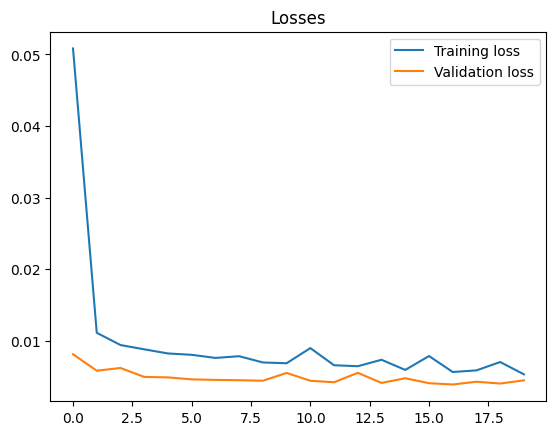

In [ ]:
input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = batch_size
layer_dim = 3
dropout = 0.2
n_epochs = 20
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = RNNModel(**model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

Для batch_size = 64 и learning_rate = 0.1
```
[1/20] Training loss: 1.5632	 Validation loss: 0.1966
[2/20] Training loss: 0.2498	 Validation loss: 0.1249
[3/20] Training loss: 0.4259	 Validation loss: 0.3354
[4/20] Training loss: 0.5416	 Validation loss: 0.2116
[5/20] Training loss: 0.5815	 Validation loss: 0.1726
[6/20] Training loss: 0.6003	 Validation loss: 0.1694
[7/20] Training loss: 0.6064	 Validation loss: 0.1667
[8/20] Training loss: 0.6038	 Validation loss: 0.1785
[9/20] Training loss: 0.6137	 Validation loss: 0.1693
[10/20] Training loss: 0.6120	 Validation loss: 0.1711
```





Для batch_size = 64 и learning_rate = 0.01
```
[1/20] Training loss: 0.1008	 Validation loss: 0.0174
[2/20] Training loss: 0.0267	 Validation loss: 0.0061
[3/20] Training loss: 0.0144	 Validation loss: 0.0054
[4/20] Training loss: 0.0103	 Validation loss: 0.0048
[5/20] Training loss: 0.0128	 Validation loss: 0.0079
[6/20] Training loss: 0.0109	 Validation loss: 0.0053
[7/20] Training loss: 0.0223	 Validation loss: 0.0697
[8/20] Training loss: 0.1723	 Validation loss: 0.0598
[9/20] Training loss: 0.0701	 Validation loss: 0.0177
[10/20] Training loss: 0.0733	 Validation loss: 0.0543
```

Для batch_size = 64 и learning_rate = 0.001
```
 [1/20] Training loss: 0.0461	 Validation loss: 0.0060
[2/20] Training loss: 0.0105	 Validation loss: 0.0054
[3/20] Training loss: 0.0094	 Validation loss: 0.0051
[4/20] Training loss: 0.0096	 Validation loss: 0.0050
[5/20] Training loss: 0.0083	 Validation loss: 0.0050
[6/20] Training loss: 0.0097	 Validation loss: 0.0050
[7/20] Training loss: 0.0093	 Validation loss: 0.0047
[8/20] Training loss: 0.0077	 Validation loss: 0.0054
[9/20] Training loss: 0.0089	 Validation loss: 0.0046
[10/20] Training loss: 0.0081	 Validation loss: 0.0045
```

Для batch_size = 96 и learning_rate = 0.1
```
[1/20] Training loss: 0.5669	 Validation loss: 0.0573
[2/20] Training loss: 0.1569	 Validation loss: 0.0434
[3/20] Training loss: 0.1899	 Validation loss: 0.0444
[4/20] Training loss: 0.2223	 Validation loss: 0.0435
[5/20] Training loss: 0.2341	 Validation loss: 0.0440
[6/20] Training loss: 0.2426	 Validation loss: 0.0439
[7/20] Training loss: 0.2474	 Validation loss: 0.0438
[8/20] Training loss: 0.2429	 Validation loss: 0.0443
[9/20] Training loss: 0.2415	 Validation loss: 0.0436
[10/20] Training loss: 0.2483	 Validation loss: 0.0450
```

Для batch_size = 96 и learning_rate = 0.01
```
[1/20] Training loss: 0.1017	 Validation loss: 0.0185
[2/20] Training loss: 0.0151	 Validation loss: 0.0053
[3/20] Training loss: 0.0110	 Validation loss: 0.0050
[4/20] Training loss: 0.0104	 Validation loss: 0.0051
[5/20] Training loss: 0.0092	 Validation loss: 0.0066
[6/20] Training loss: 0.0147	 Validation loss: 0.0046
[7/20] Training loss: 0.0108	 Validation loss: 0.0081
[8/20] Training loss: 0.0086	 Validation loss: 0.0045
[9/20] Training loss: 0.0086	 Validation loss: 0.0047
[10/20] Training loss: 0.0079	 Validation loss: 0.0046
```



Для batch_size = 96 и learning_rate = 0.001
```
[1/20] Training loss: 0.0326	 Validation loss: 0.0064
[2/20] Training loss: 0.0096	 Validation loss: 0.0052
[3/20] Training loss: 0.0088	 Validation loss: 0.0058
[4/20] Training loss: 0.0079	 Validation loss: 0.0051
[5/20] Training loss: 0.0074	 Validation loss: 0.0046
[6/20] Training loss: 0.0072	 Validation loss: 0.0042
[7/20] Training loss: 0.0065	 Validation loss: 0.0041
[8/20] Training loss: 0.0066	 Validation loss: 0.0083
[9/20] Training loss: 0.0083	 Validation loss: 0.0040
[10/20] Training loss: 0.0062	 Validation loss: 0.0039
```

Для batch_size = 128 и learning_rate = 0.1
```
[1/20] Training loss: 1.4230	 Validation loss: 0.5000
[2/20] Training loss: 0.1341	 Validation loss: 0.0435
[3/20] Training loss: 0.0841	 Validation loss: 0.0668
[4/20] Training loss: 0.1069	 Validation loss: 0.0443
[5/20] Training loss: 0.1138	 Validation loss: 0.0444
[6/20] Training loss: 0.1341	 Validation loss: 0.0852
[7/20] Training loss: 0.1455	 Validation loss: 0.1167
[8/20] Training loss: 0.1358	 Validation loss: 0.0768
[9/20] Training loss: 0.1291	 Validation loss: 0.0681
[10/20] Training loss: 0.1392	 Validation loss: 0.0641
```

Для batch_size = 128 и learning_rate = 0.01
```
[1/20] Training loss: 0.1519	 Validation loss: 0.0420
[2/20] Training loss: 0.0331	 Validation loss: 0.0108
[3/20] Training loss: 0.0126	 Validation loss: 0.0057
[4/20] Training loss: 0.0106	 Validation loss: 0.0063
[5/20] Training loss: 0.0094	 Validation loss: 0.0053
[6/20] Training loss: 0.0091	 Validation loss: 0.0048
[7/20] Training loss: 0.0096	 Validation loss: 0.0050
[8/20] Training loss: 0.0089	 Validation loss: 0.0050
[9/20] Training loss: 0.0081	 Validation loss: 0.0043
[10/20] Training loss: 0.0095	 Validation loss: 0.0059
```

Для batch_size = 128 и learning_rate = 0.001

```
[1/20] Training loss: 0.0802	 Validation loss: 0.0184
[2/20] Training loss: 0.0201	 Validation loss: 0.0058
[3/20] Training loss: 0.0110	 Validation loss: 0.0051
[4/20] Training loss: 0.0099	 Validation loss: 0.0051
[5/20] Training loss: 0.0092	 Validation loss: 0.0047
[6/20] Training loss: 0.0084	 Validation loss: 0.0046
[7/20] Training loss: 0.0082	 Validation loss: 0.0045
[8/20] Training loss: 0.0075	 Validation loss: 0.0044
[9/20] Training loss: 0.0077	 Validation loss: 0.0044
[10/20] Training loss: 0.0072	 Validation loss: 0.0043
```



In [ ]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        col_values = df[col].to_numpy().reshape(-1, 1)
        df[col] = scaler.inverse_transform(col_values).ravel()
    return df

def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    vals = vals.reshape(-1, 1)
    preds = preds.reshape(-1, 1)
    df_result = pd.DataFrame(data={"value": vals.flatten(), "prediction": preds.flatten()}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, ["value", "prediction"])
    df_result = df_result.round({"value": 0, "prediction": 0})
    return df_result

df_result = format_predictions(predictions, values, X_test, scaler)
df_result

,value,prediction
Date,,
2020-10-07,18.0,14.0
2020-10-08,15.0,15.0
2020-10-09,15.0,14.0
2020-10-10,15.0,14.0
2020-10-11,15.0,13.0
...,...,...
2022-04-19,21.0,15.0
2022-04-20,17.0,16.0
2022-04-21,9.0,16.0


In [ ]:
def calculate_metrics(df):
    df_cleaned = df.dropna(subset=['value', 'prediction'])

    result_metrics = {'mae': mean_absolute_error(df_cleaned.value, df_cleaned.prediction),
                      'rmse': mean_squared_error(df_cleaned.value, df_cleaned.prediction) ** 0.5,
                      'r2': r2_score(df_cleaned.value, df_cleaned.prediction)}

    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("R^2 Score:                 ", result_metrics["r2"])

    return result_metrics

result_metrics = calculate_metrics(df_result)

Mean Absolute Error:        3.567857
Root Mean Squared Error:    4.48529341062211
R^2 Score:                  0.9053461831332009


In [ ]:
def temp_by_month(df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
    df = df.reset_index(inplace=False)
    start_date = pd.to_datetime(start_date, format='%Y-%m-%d')
    end_date = pd.to_datetime(end_date, format='%Y-%m-%d')
    return df[(start_date <= df["Date"]) & (df["Date"] <= end_date)]


temp_by_month(df_result, "2022-01-01", "2022-02-1")

,Date,value,prediction
447,2022-01-01,-4.0,-10.0
448,2022-01-02,-3.0,-8.0
449,2022-01-03,-11.0,-8.0
450,2022-01-04,-15.0,-8.0
451,2022-01-05,-16.0,-11.0
452,2022-01-06,-7.0,-12.0
453,2022-01-07,-0.0,-10.0
454,2022-01-08,-8.0,-7.0
455,2022-01-09,-11.0,-8.0
456,2022-01-10,-12.0,-8.0


<Axes: xlabel='Date'>

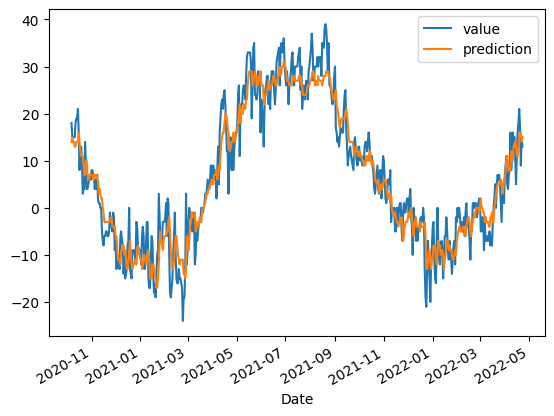

In [ ]:
df_result.plot()